In [1]:
#Authors: Akbota Assan (A69037121), Devana Perupurayil (A69034326), Melissa Medina-Peregrina (A59016508)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from iminuit import Minuit, cost
from iminuit.cost import LeastSquares
from scipy.stats import norm
import scipy.stats
from sklearn.metrics import auc
import emcee
import corner

## Step 1

In [2]:
detector_A = pd.read_csv('DetectorA.csv', sep=',', header=0, names=['ID', "cnn_score", "Energy"])
detector_B = pd.read_csv('DetectorB.csv', sep=',', header=0, names=['ID', "cnn_score", "Energy"])
detector_C = pd.read_csv('DetectorC.csv', sep=',', header=0, names=['ID', "cnn_score", "Energy"])
detector_Target = pd.read_csv('DetectorTarget.csv', sep=',', header=0, names=['ID', "cnn_score", "Energy"])

In [3]:
detector_A

,ID,cnn_score,Energy
0,371804.0,0.302,2614.488
1,594581.0,0.600,1705.200
2,1032837.0,0.481,1267.713
3,959143.0,0.154,2615.730
4,930779.0,0.093,1699.004
...,...,...,...
39995,440702.0,0.006,1465.075
39996,970685.0,0.018,1350.027
39997,226138.0,0.564,1126.152
39998,374147.0,0.587,1350.153


In [4]:
A_min_energy = detector_A["Energy"].min()
A_max_energy = detector_A["Energy"].max()
B_min_energy = detector_B["Energy"].min()
B_max_energy = detector_B["Energy"].max()
C_min_energy = detector_C["Energy"].min()
C_max_energy = detector_C["Energy"].max()
Target_min_energy = detector_Target["Energy"].min()
Target_max_energy = detector_Target["Energy"].max()

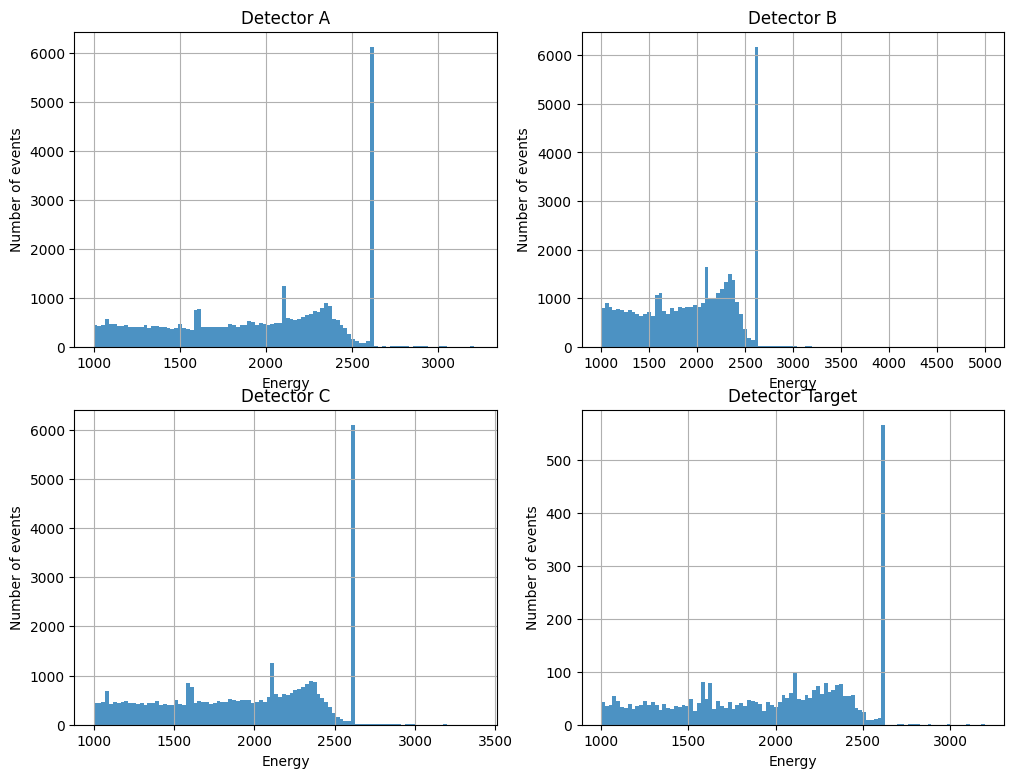

In [5]:
plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
plt.hist(detector_A["Energy"], bins=100, alpha=0.8, range=(A_min_energy, A_max_energy))
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector A')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.hist(detector_B["Energy"], bins=100, alpha=0.8, range=(B_min_energy, B_max_energy))
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector B')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.hist(detector_C["Energy"], bins=100, alpha=0.8, range=(C_min_energy, C_max_energy))
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector C')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.hist(detector_Target["Energy"], bins=100, alpha=0.8, range=(Target_min_energy, Target_max_energy))
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector Target')
plt.grid(True)

## Step 2

True Positive Rate: 0.801


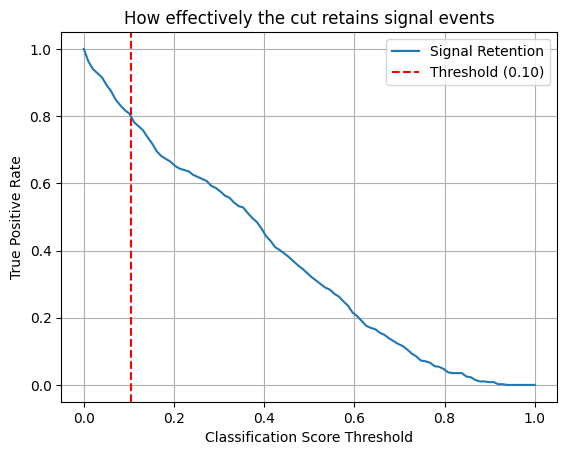

In [6]:
#Step 2

#Identify energy range around the 1592 keV peak
Peak_A = (detector_A["Energy"]>=1589)&(detector_A["Energy"]<=1595)
Peak_A_events = detector_A[Peak_A] 

#Take values with cnn_score above 90% as acceptable threshold
Threshold = np.percentile(Peak_A_events["cnn_score"], 20)
#print(Threshold)
Thresholds = np.linspace(0, 1, 100)

True_Positive = len(Peak_A_events[Peak_A_events["cnn_score"]>=Threshold])
False_Negative = len(Peak_A_events[Peak_A_events["cnn_score"]<Threshold])
#print(False_Negative)
Signal = True_Positive+False_Negative
True_Positive_Rate = True_Positive/Signal
print(f"True Positive Rate: {True_Positive_Rate:.3f}")
        
# Plot the signal retention as a function of threshold
plt.plot(Thresholds, [len(Peak_A_events[Peak_A_events["cnn_score"] >= t]) / len(Peak_A_events) for t in Thresholds], label="Signal Retention")
plt.axvline(Threshold, color='r', linestyle='--', label=f"Threshold ({Threshold:.2f})")
plt.xlabel("Classification Score Threshold")
plt.ylabel("True Positive Rate")
plt.title("How effectively the cut retains signal events")
plt.legend()
plt.grid()
plt.show()

## Step 3

False Positive Rate: 0.190
Area under curve: 0.860


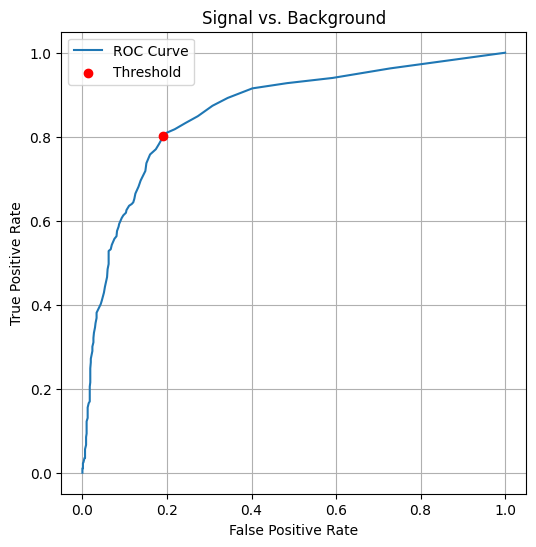

In [7]:
#Step 3

#Identify energy range around the 2103 keV peak
Peak_B = (detector_B["Energy"]>=2100)&(detector_B["Energy"]<=2106)
Peak_B_events = detector_B[Peak_B]

#Events in the 2103 keV region

False_positive = len(Peak_B_events[Peak_B_events["cnn_score"] >= Threshold])
True_Negative = len(Peak_B_events[Peak_B_events["cnn_score"]<Threshold]) 
Background = False_positive+True_Negative
False_Positive_Rate = False_positive/Background
print(f"False Positive Rate: {False_Positive_Rate:.3f}")

#Different thresholds
#thresholds = np.linspace(0, 1, 100)
TPR_values = [(Peak_A_events["cnn_score"] >= t).sum()/Signal for t in Thresholds]
FPR_values = [(Peak_B_events["cnn_score"] >= t).sum()/Background for t in Thresholds]

ROC_AUC = auc(FPR_values,TPR_values)
print(f"Area under curve: {ROC_AUC:.3f}")

plt.figure(figsize=(6, 6))
plt.plot(FPR_values, TPR_values, label="ROC Curve")
plt.scatter(False_Positive_Rate, True_Positive_Rate, color="red", label="Threshold", zorder=3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Signal vs. Background")
plt.legend()
plt.grid()
plt.show()

## Step 4

<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
/var/folders/rt/hh_hxvxx60x6xkktcx2rmf2r0000gn/T/ipykernel_3252/2641089022.py:11: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(E, Gaussian_PDF, label=r'Gaussian PDF''\n''($\mu=2039$ keV, $\sigma=1$ keV)', color='r')


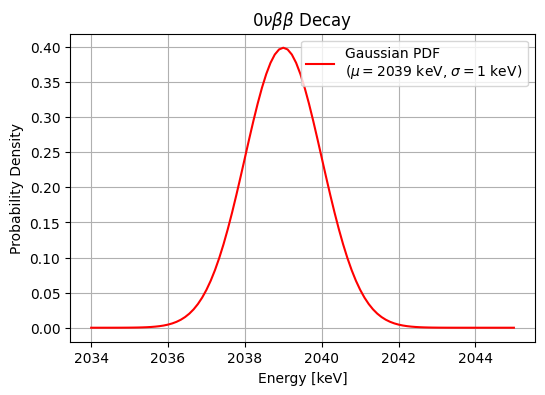

In [8]:
#Step 4

#Gaussian parameters sigma and peak energy
sigma = 1 
mu = 2039
E = np.linspace(2034, 2045, 100)

Gaussian_PDF = norm.pdf(E,mu,sigma)

plt.figure(figsize=(6, 4))
plt.plot(E, Gaussian_PDF, label=r'Gaussian PDF''\n''($\mu=2039$ keV, $\sigma=1$ keV)', color='r')
plt.legend(fontsize=8)
plt.xlabel("Energy [keV]")
plt.ylabel("Probability Density")
plt.title("$0\\nu\\beta\\beta$ Decay")
plt.legend()
plt.grid()
plt.show()

## Step 5

We will be removing data points that do not pass a certain theshold calculated earlier.

In [9]:
detectorA_cut = detector_A[
    (detector_A['cnn_score'] >= Threshold)
]
detectorB_cut = detector_B[
    (detector_B['cnn_score'] >= Threshold)
]

detectorC_cut = detector_C[
    (detector_C['cnn_score'] >= Threshold)
]

target_cut = detector_Target[
    (detector_Target['cnn_score'] >= Threshold)
]

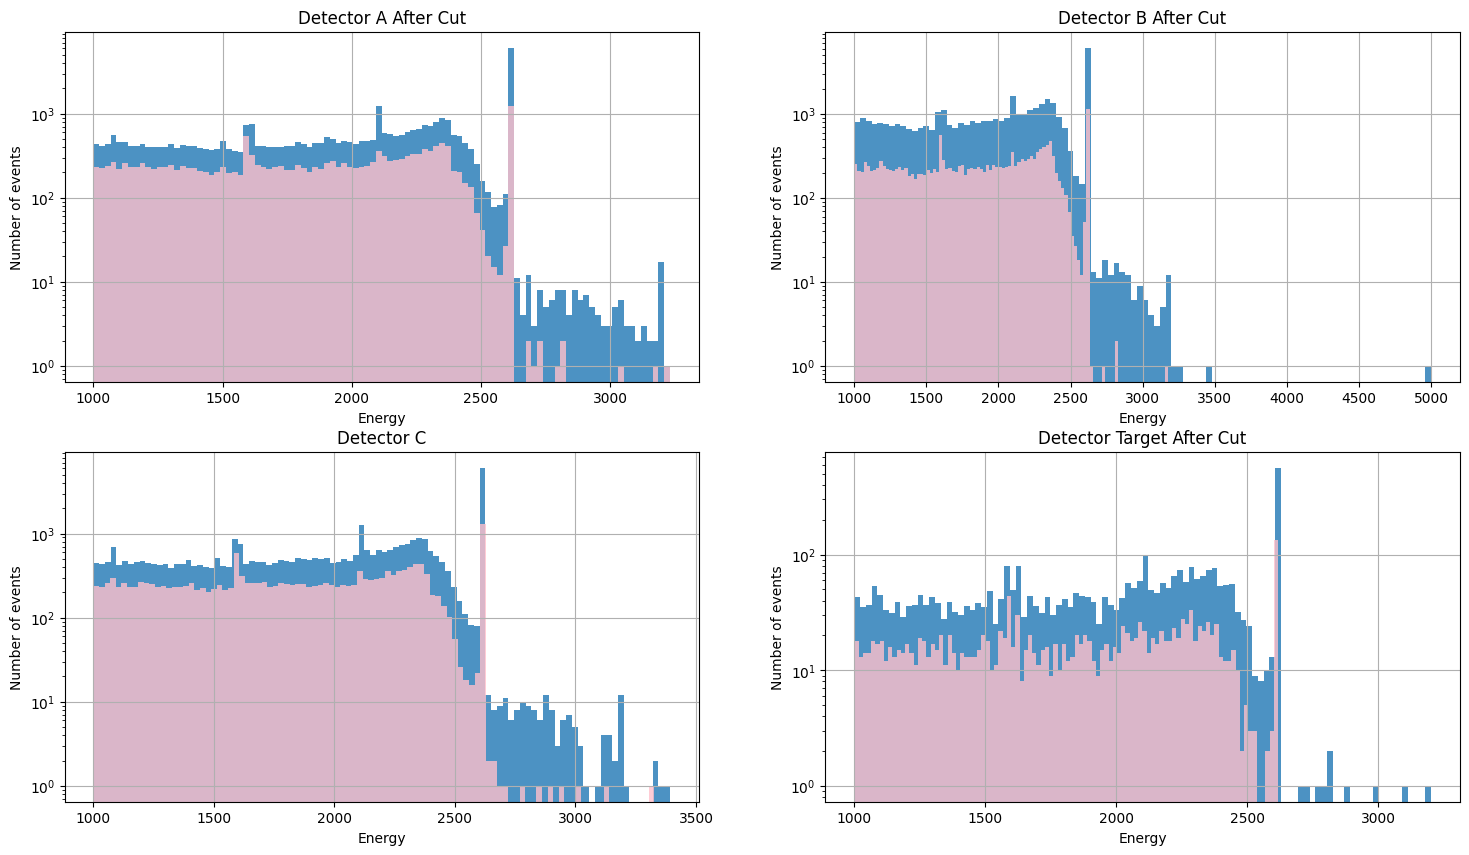

In [10]:
plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
plt.hist(detector_A["Energy"], bins=100, alpha=0.8)
plt.hist(detectorA_cut["Energy"], bins=100, alpha=0.8, color = 'pink')
plt.yscale('log')
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector A After Cut')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.hist(detector_B["Energy"], bins=100, alpha=0.8)
plt.hist(detectorB_cut["Energy"], bins=100, alpha=0.8,  color = 'pink')
plt.yscale('log')
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector B After Cut')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.hist(detector_C["Energy"], bins=100, alpha=0.8)
plt.hist(detectorC_cut["Energy"], bins=100, alpha=0.8, color = 'pink')
plt.yscale('log')
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector C')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.hist(detector_Target["Energy"], bins=100, alpha=0.8)
plt.hist(target_cut["Energy"], bins=100, alpha=0.8, color = 'pink')
plt.yscale('log')
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector Target After Cut')
plt.grid(True)

### Gaussian PDF

In [11]:
from statistics import NormalDist

normA = NormalDist.from_samples(detectorA_cut['Energy'])
normB = NormalDist.from_samples(detectorB_cut['Energy'])
normC = NormalDist.from_samples(detectorC_cut['Energy'])
normTarget = NormalDist.from_samples(target_cut['Energy'])

In [12]:
pdfA_x = np.linspace(normA.mean - 3*normA.stdev, normA.mean + 3*normA.stdev, 100) 
pdfA_values = norm.pdf(pdfA_x, normA.mean, normA.stdev)

pdfB_x = np.linspace(normB.mean - 3*normB.stdev, normB.mean + 3*normB.stdev, 100) 
pdfB_values = norm.pdf(pdfB_x, normB.mean, normB.stdev)

pdfC_x = np.linspace(normC.mean - 3*normC.stdev, normC.mean + 3*normC.stdev, 100) 
pdfC_values = norm.pdf(pdfC_x, normC.mean, normC.stdev)

pdfTarget_x = np.linspace(normTarget.mean - 3*normTarget.stdev, normTarget.mean + 3*normTarget.stdev, 100) 
pdfTarget_values = norm.pdf(pdfTarget_x, normTarget.mean, normTarget.stdev)

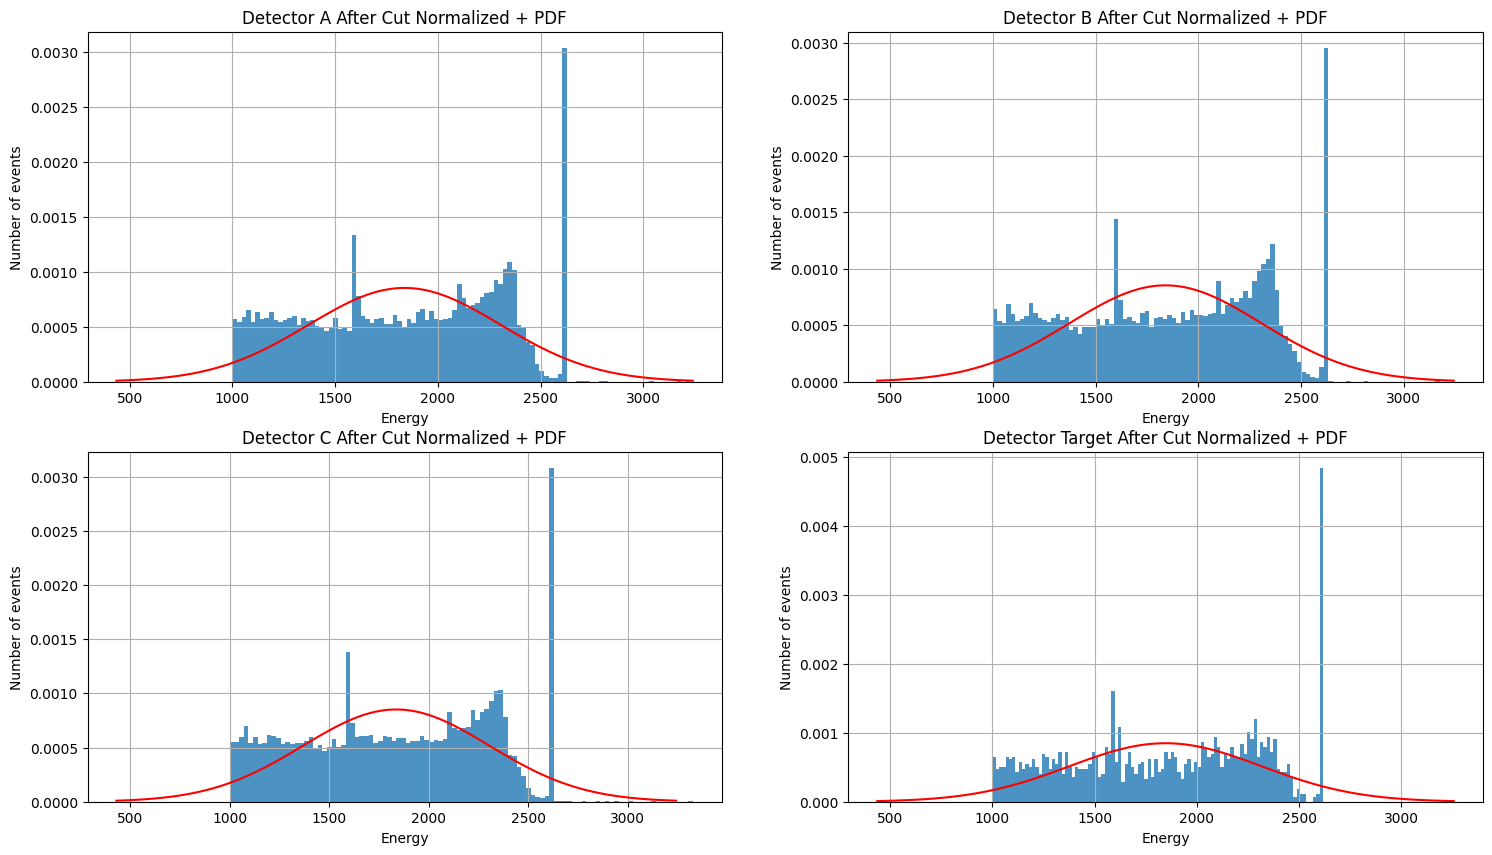

In [13]:
plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
plt.hist(detectorA_cut["Energy"], density=True,  bins=100, alpha=0.8, label='Detector A Histogram')
plt.plot(pdfA_x, pdfA_values, color='red')
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector A After Cut Normalized + PDF')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.hist(detectorB_cut["Energy"], density=True, bins=100, alpha=0.8, label='Detector B Histogram')
plt.plot(pdfB_x, pdfB_values, color='red')
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector B After Cut Normalized + PDF')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.hist(detectorC_cut["Energy"], density=True, bins=100, alpha=0.8, label='Detector C Histogram')
plt.plot(pdfC_x, pdfC_values, color='red')
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector C After Cut Normalized + PDF')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.hist(target_cut["Energy"], density=True, bins=100, alpha=0.8, label='Detector_Target Histogram')
plt.plot(pdfTarget_x, pdfTarget_values, color='red')
plt.xlabel('Energy')
plt.ylabel('Number of events')
plt.title('Detector Target After Cut Normalized + PDF')
plt.grid(True)

## Step 6

In [14]:
pdfA_values

array([9.47624459e-06, 1.13449162e-05, 1.35322845e-05, 1.60822104e-05,
       1.90425523e-05, 2.24651523e-05, 2.64057420e-05, 3.09237517e-05,
       3.60820144e-05, 4.19463493e-05, 4.85850168e-05, 5.60680356e-05,
       6.44663556e-05, 7.38508832e-05, 8.42913604e-05, 9.58551008e-05,
       1.08605592e-04, 1.22600981e-04, 1.37892452e-04, 1.54522541e-04,
       1.72523389e-04, 1.91914999e-04, 2.12703507e-04, 2.34879534e-04,
       2.58416654e-04, 2.83270022e-04, 3.09375224e-04, 3.36647380e-04,
       3.64980567e-04, 3.94247584e-04, 4.24300101e-04, 4.54969228e-04,
       4.86066521e-04, 5.17385424e-04, 5.48703164e-04, 5.79783078e-04,
       6.10377338e-04, 6.40230062e-04, 6.69080725e-04, 6.96667853e-04,
       7.22732888e-04, 7.47024181e-04, 7.69301001e-04, 7.89337491e-04,
       8.06926464e-04, 8.21882972e-04, 8.34047532e-04, 8.43288961e-04,
       8.49506732e-04, 8.52632788e-04, 8.52632788e-04, 8.49506732e-04,
       8.43288961e-04, 8.34047532e-04, 8.21882972e-04, 8.06926464e-04,
      

In [15]:
pdfA_values = pdfA_values / np.sum(pdfA_values)
pdfB_values = pdfB_values / np.sum(pdfB_values)
pdfC_values = pdfC_values / np.sum(pdfC_values)
Gaussian_PDF = Gaussian_PDF / np.sum(Gaussian_PDF)


Best-fit parameters: [1274.80812658  225.41639944  211.0017255     2.39564867]


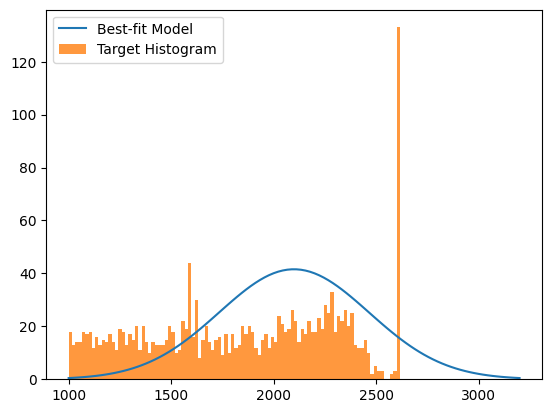

In [16]:

# Define the model parameters
def model(params, energy):
    theta_A, theta_B, theta_C, delta_NLDBD = params
    # Combine PDFs for detectors A, B, and C with NLDBD signal
    pdf_A = pdfA_values * theta_A
    pdf_B = pdfB_values * theta_B
    pdf_C = pdfC_values * theta_C
    pdf_NLDBD = Gaussian_PDF * delta_NLDBD
    return (pdf_A + pdf_B + pdf_C + pdf_NLDBD)
    
# Define the likelihood function
def ln_likelihood(params, energy, target_hist):
    model_values = np.maximum(model(params, energy), 1e-10)
    # Calculate the likelihood using Poisson distribution
    likelihood = np.sum(target_hist * np.log(model_values) - model_values)
    return likelihood

# Define the prior function with Gaussian priors for theta_A and theta_B, and Jeffrey's prior for theta_C and delta_NLDBD
def ln_prior(params):
    theta_A, theta_B, theta_C, delta_NLDBD = params
    
    theta_A_mean = 1350
    theta_A_std = 100
    theta_B_mean = 770
    theta_B_std = 270
    
    prior_theta_A = -0.5 * ((theta_A - theta_A_mean) / theta_A_std)**2 
    prior_theta_B = -0.5 * ((theta_B - theta_B_mean) / theta_B_std)**2 
    prior_theta_C = -0.5 * ((theta_C - normC.mean) / normC.stdev) **2
    
    # Uniform prior for delta_NLDBD
    delta_NLDBD_min, delta_NLDBD_max = 0, 200  # Define the range for delta_NLDBD
    if delta_NLDBD < delta_NLDBD_min or delta_NLDBD > delta_NLDBD_max:
        return -np.inf
    prior_delta_NLDBD = 0.0

    # if theta_C > 0 and delta_NLDBD >= 0:
    #     prior_theta_C = 0.0
    #     prior_delta_NLDBD = 0.0
    # else:
    #     return -np.inf
    
    return prior_theta_A + prior_theta_B + prior_theta_C + prior_delta_NLDBD

# Define the posterior function
def ln_posterior(params, energy, target_hist):
    lp = ln_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    
    ll = ln_likelihood(params, energy, target_hist)
    if not np.isfinite(ll):
        return -np.inf
    
    return lp + ll

# Prepare the data for fitting
energy_bins = np.linspace(Target_min_energy, Target_max_energy, 100)
target_hist, _ = np.histogram(target_cut["Energy"], bins=100, range=(Target_min_energy, Target_max_energy), density=False)

# Initial guesses for parameters
initial_guess = [1350, 770, 1000, 100]  # theta_A, theta_B, theta_C, delta_NLDBD

# MCMC setup
nwalkers = 50
ndim = 4
p0 = [initial_guess + np.random.randn(ndim) * 0.1 for _ in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(energy_bins, target_hist))
sampler.run_mcmc(p0, 10000)  # Run for 1000 steps

burn_in = 500
# samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))
samples = sampler.get_chain(discard=burn_in, flat=True)

# Get the best-fit parameters
best_fit_params = np.median(samples, axis=0)
print("Best-fit parameters:", best_fit_params)

# Plot the best-fit model
plt.plot(energy_bins, model(best_fit_params, energy_bins), label='Best-fit Model')
plt.hist(target_cut["Energy"], bins=100, alpha=0.8, density=False, label='Target Histogram')
plt.legend()
plt.show()


In [17]:
mean_values = np.mean(samples, axis=0)
uncertainties = np.std(samples, axis=0)

print("Mean Values:", mean_values)
print("Uncertainties:", uncertainties)


Mean Values: [1275.3928361   226.70266324  209.84514325    3.46158983]
Uncertainties: [ 98.97818221 233.78514864 246.97305099   3.46652344]


## Step 7

90% Confidence Level Upper Limit for delta_NLDBD: 7.97


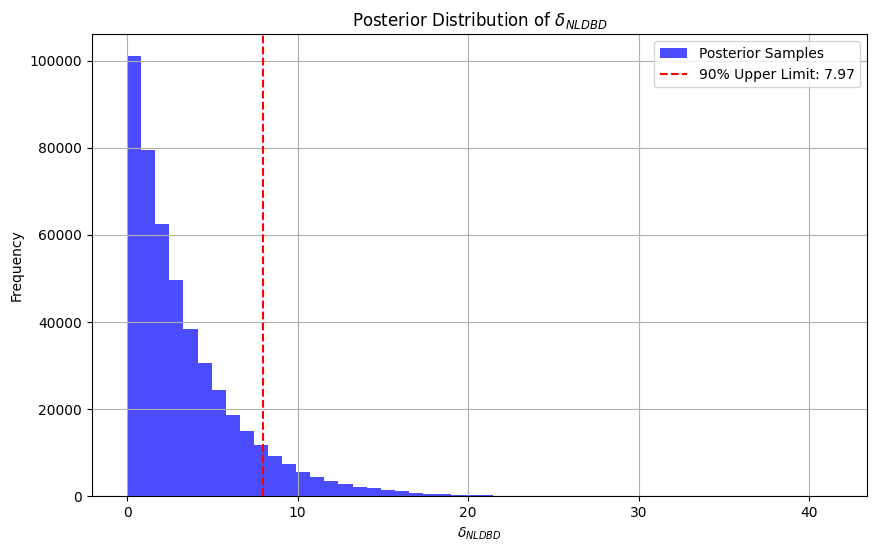

In [18]:
# Extract delta_NLDBD samples (4th column, index 3)
delta_NLDBD_samples = samples[:, 3]

# Calculate the 90% upper limit
upper_limit_90 = np.percentile(delta_NLDBD_samples, 90)

print(f"90% Confidence Level Upper Limit for delta_NLDBD: {upper_limit_90:.2f}")

# Optional: Plot the posterior distribution with the upper limit marked
plt.figure(figsize=(10, 6))
plt.hist(delta_NLDBD_samples, bins=50, alpha=0.7, color='blue', label='Posterior Samples')
plt.axvline(upper_limit_90, color='red', linestyle='--', label=f'90% Upper Limit: {upper_limit_90:.2f}')
plt.xlabel(r'$\delta_{NLDBD}$')
plt.ylabel('Frequency')
plt.title(r'Posterior Distribution of $\delta_{NLDBD}$')
plt.legend()
plt.grid(True)
plt.show()


### Step 8

In [19]:
best_fit_params

array([1274.80812658,  225.41639944,  211.0017255 ,    2.39564867])

In [21]:
# Set delta_NLDBD = 0 in best-fit from observed data to generate Asimov
energy_bins = np.linspace(Target_min_energy, Target_max_energy, 100)

best_fit_background_only = best_fit_params.copy()
best_fit_background_only[3] = 0  # Background-only hypothesis

bin_centers = 0.5 * (energy_bins[:-1] + energy_bins[1:])
# asimov_data = model(best_fit_background_only, bin_centers)

ndim = 4
nwalkers = 50

initial_guess = best_fit_background_only
p0 = [initial_guess + np.random.randn(ndim) * 0.1 for _ in range(nwalkers)]


sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(energy_bins, target_hist))
sampler.run_mcmc(p0, 10000, progress=True)

burn_in = 500

samples_asimov = sampler.get_chain(discard=burn_in, flat=True)
best_fit_params_asimov = np.median(samples_asimov, axis=0)
print("Best-fit parameters Asimov:", best_fit_params_asimov)

  0%|                                                                                                                                                                                       | 0/10000 [00:00<?, ?it/s]/Users/akbotaassan/Desktop/UCSD/Jupyter_Notebook/venv/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1954.75it/s]


Best-fit parameters Asimov: [1275.4083298   233.38830894  203.40669787    2.45760978]


In [22]:
# Extract delta_NLDBD samples (4th column, index 3)
delta_NLDBD_samples = samples_asimov[:, 3]

# Calculate the 90% upper limit
upper_limit_90 = np.percentile(delta_NLDBD_samples, 90)

In [23]:
upper_limit_90

np.float64(8.171302230688156)

In [24]:
np.median(delta_NLDBD_samples)

np.float64(2.457609780797631)